**第9章**

In [1]:
# 5yr 3% 満期一括債(bullet)
from myABBR import * ; import myUtil as mu
tradeDT,               issDT,      matDT,      cpnRT, mktYLD                =\
jDT(2024,4,15), jDT(2024,4,17), jDT(2029,4,17), 0.03,  0.03;  setEvDT(tradeDT)

# 債券スケジュールとオブジェクト
bondSCD = ql.Schedule(issDT, matDT, pdFreqSA, calWK, unADJ, unADJ, dtGENb, EoMf)
blltOBJ = ql.FixedRateBond(Tp2, parAMT, bondSCD, [cpnRT], dcAAb)

# 価格 >> 利回り計算
PrToYLD = blltOBJ.bondYield(parPR, dcAAb, cmpdCMP, freqSA)
print(f'Bullet債 {parPR:.2f}円の利回り: {PrToYLD:.3%}')

Bullet債 100.00円の利回り: 3.000%


In [2]:
# 5NC1マルチコール, スワップションパラメータ (NC=1yr/freqSA=2)
NC, spdRT,      payRcv,          aa,  sgm,   nSTEP   =\
2,   0.0, ql.VanillaSwap.Payer, 0.03, 0.01,   12*5

# フラットカーブ, Hull-Whiteモデル
_,ffCvHDL = mu.ffTSH(tradeDT+Tp2, mktYLD, dcAAb, cmpdCMP, freqSA)
ffIX      = ql.Libor('ffIX', pD('6M'), Tp2, jpyFX, calWK, dcAAb, ffCvHDL)
ffIX.addFixing(tradeDT, mktYLD, True)
hwMDL     = ql.HullWhite(ffCvHDL, aa, sgm)

# コーラブル債(callPrice 100)
callPR    = ql.BondPrice(parPR, ql.BondPrice.Clean)
callSCD   = ql.CallabilitySchedule()
for dd in list(bondSCD)[NC:] :
                 callSCD.append(ql.Callability(callPR, ql.Callability.Call, dd))
callBndOBJ= ql.CallableFixedRateBond(Tp2, parAMT, bondSCD,[cpnRT], dcAAb, unADJ,
                                                          parPR, issDT, callSCD)
# エンジン設定と評価
treeBndENG= ql.TreeCallableFixedRateBondEngine(hwMDL, nSTEP)
callBndOBJ.setPricingEngine(treeBndENG)
callBndPR = callBndOBJ.cleanPrice()
PrToYLD   = callBndOBJ.bondYield(callBndPR, dcAAb, cmpdCMP, freqSA)
print(f'Callable bond: {callBndPR:.6f}  ', f'yield: {PrToYLD:.3%}')

Callable bond: 98.069190   yield: 3.423%


In [3]:
# バミューダンスワップション
swapOBJ   = ql.VanillaSwap(payRcv, parAMT, bondSCD,       cpnRT, dcAAb,
                                          bondSCD, ffIX, spdRT, dcAAb)
swptnOBJ  = ql.Swaption(swapOBJ, ql.BermudanExercise(list(bondSCD)[NC:]))

# バミューダン評価
treeSwpENG= ql.TreeSwaptionEngine(hwMDL, nSTEP)
swptnOBJ.setPricingEngine(treeSwpENG)
swptnNPV  = swptnOBJ.NPV()
print(f'Swaption NPV: {swptnNPV:,.6f},  ', 
      f'Callable bond:{parPR-swptnNPV/parAMT*100:,.6f} (=100-NPV)')

Swaption NPV: 1.946943,   Callable bond:98.053057 (=100-NPV)


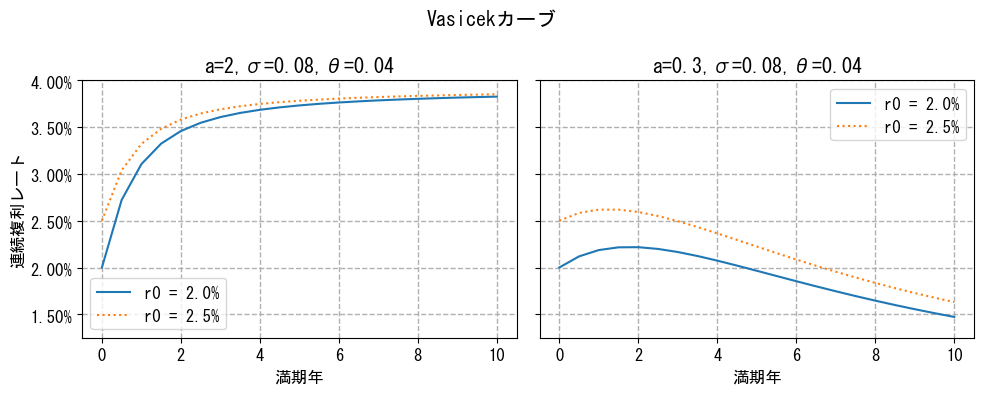

In [4]:
from myABBR import * ; plt.rcParams.update({"font.size":12})

# Vasicek B関数 A関数 RR複利関数
def vB(tt,TT,aa=0.03):
    return (1-np.exp(-aa*(TT-tt)))/aa

def vA(tt,TT,aa=0.03, sgm=0.01, tht=0.05):
    '''sgm:short rate Vol, theta=tht:short rate Limit'''
    aa2 = aa**2 ; sgm2 = sgm**2
    return (sgm2/(2*aa2))*(TT-tt-vB(tt,TT,aa)) \
          - (sgm2*vB(tt,TT,aa)**2)/(4*aa) - tht*(TT-tt-vB(tt,TT,aa))
            
def vR(tt,TT, tht=0.05, aa=0.03, sgm=0.01, r0=0.05):
    if TT == 0: return r0
    else:       return -(vA(tt,TT,aa,sgm,tht) - r0*vB(tt,TT,aa) )/(TT-tt)

# カーブ計算
tmGRD     = np.arange(0, 10.5, 0.5)
# (左側)    theta, aa,  sgm        r0     
paraVSCK  = [0.04, 2.0, 0.08]
aa2_r02   = [vR(0, xx, *paraVSCK, 0.02   ) for xx in tmGRD]
aa2_r025  = [vR(0, xx, *paraVSCK, 0.025  ) for xx in tmGRD]
# (右側)    theta, aa,   sgm     
paraVSCK  = [0.04, 0.3, 0.08] 
aa03_r02  = [vR(0, xx, *paraVSCK, 0.02   ) for xx in tmGRD]
aa03_r025 = [vR(0, xx, *paraVSCK, 0.025  ) for xx in tmGRD]
    
# 2つのグラフ描写
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True, 
                            tight_layout=True)  ; fig.suptitle('Vasicekカーブ')
# (左側)
ax[0].plot(tmGRD, aa2_r02,   label='r0 = 2.0%', linestyle='-')   
ax[0].plot(tmGRD, aa2_r025,  label='r0 = 2.5%', linestyle=':')
# (右側)
ax[1].plot(tmGRD, aa03_r02,  label='r0 = 2.0%', linestyle='-')   
ax[1].plot(tmGRD, aa03_r025, label='r0 = 2.5%', linestyle=':')
# グラフ装飾 (グリッド, タイトル, x軸名)
ax[0].grid(linestyle='--',linewidth=1) ; ax[1].grid(linestyle='--',linewidth=1)
ax[0].set_title("a=2,σ=0.08,θ=0.04") ; ax[1].set_title("a=0.3,σ=0.08,θ=0.04")
ax[0].set_xlabel("満期年")             ; ax[1].set_xlabel("満期年")
ax[0].legend()                         ; ax[1].legend()
# y軸 (軸名, min/max, %表示)
ax[0].set_ylabel("連続複利レート")     ; ax[0].set_ylim([0.0125, 0.04])
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1,2))  # %表示

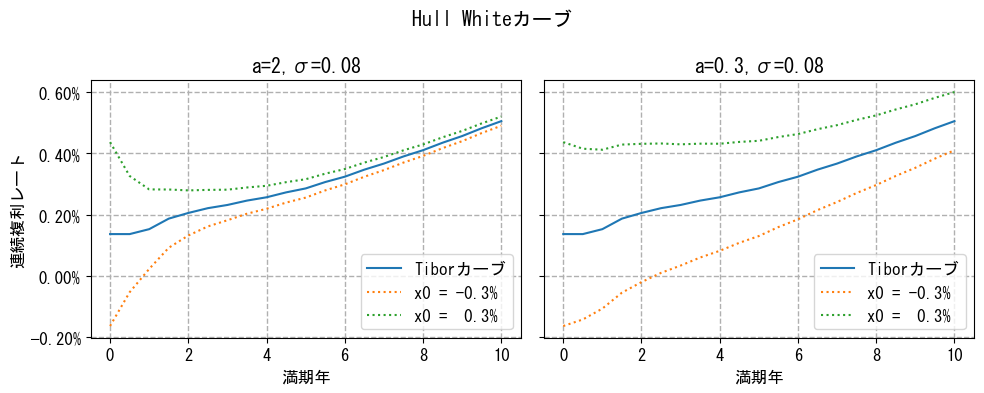

In [5]:
from myABBR import *; import myUtil as mu; plt.rcParams.update({"font.size":12})
# Tiborカーブ準備
tradeDT = mu.jDT(2022,8,19) ; mu.setEvDT(tradeDT)
crvDATA = [('depo','6m',0.13636), ('swap','1y',0.15249), ('swap','18m',0.18742), 
           ('swap','2y',0.20541), ('swap','3y',0.23156), ('swap','4y',0.25653), 
           ('swap','5y',0.28528), ('swap','6y',0.32341), ('swap','7y',0.36591), 
           ('swap','8y',0.40906), ('swap','9y',0.45471), ('swap','10y',0.50224)]
tbrIX, tbCrvOBJ, tbCrvHDL, tbParRT = mu.makeTiborCurve(crvDATA)

# Hull-White B関数 V関数  A関数 R複利関数の定義
def BB(tt,TT,aa):
    return (1-np.exp(-aa*(TT-tt)))/aa

def VV(tt,TT, aa, sgm): 
    return (sgm**2/aa**2)*(TT-tt +(2/aa)*np.exp(-aa*(TT-tt))\
        -(1/(2*aa))*np.exp(-2*aa*(TT-tt))-3/(2*aa))

def AA(tt,TT, aa, sgm):
    '''sgm:short rate Vol'''
    return 0.5*(VV(tt,TT,aa,sgm)-VV(0,TT,aa,sgm)+VV(0,tt,aa,sgm))
            
def RR(tt,TT, CrvOBJ, aa=0.03, sgm=0.01, x0=0):
    if TT == 0: return tbParRT[0]+x0
    else: return -(np.log( CrvOBJ.discount(TT)/CrvOBJ.discount(tt) )
                            + AA(tt,TT,aa,sgm) - x0*BB(tt,TT,aa))/(TT-tt)
# カーブ計算
tmGRD   = np.arange(0, 10.5, 0.5)
# (左側)   CrvOBJ     aa   sgm    x0
paraHW  = [tbCrvOBJ, 2.0, 0.08]      
aa1_x0  = [RR(0, xx, *paraHW,  0.000 ) for xx in tmGRD]
aa1_x1  = [RR(0, xx, *paraHW, -0.003 ) for xx in tmGRD]
aa1_x2  = [RR(0, xx, *paraHW,  0.003 ) for xx in tmGRD]
# (右側)   CrvOBJ     aa   sgm
paraHW  = [tbCrvOBJ, 0.3, 0.08]      
aa3_x0  = [RR(0, xx, *paraHW,  0.000 ) for xx in tmGRD]
aa3_x1  = [RR(0, xx, *paraHW, -0.003 ) for xx in tmGRD]
aa3_x2  = [RR(0, xx, *paraHW,  0.003 ) for xx in tmGRD]

# 2つのグラフ描写
fig, ax = plt.subplots(1,2, figsize=(10,4), sharex=True, sharey=True, 
                            tight_layout=True)  ; fig.suptitle('Hull Whiteカーブ')
# (左側)
ax[0].plot(tmGRD, aa1_x0,  label='Tiborカーブ', linestyle='-')   
ax[0].plot(tmGRD, aa1_x1,  label='x0 = -0.3%', linestyle=':')
ax[0].plot(tmGRD, aa1_x2,  label='x0 =  0.3%', linestyle=':')
# (右側)
ax[1].plot(tmGRD, aa3_x0,  label='Tiborカーブ', linestyle='-')   
ax[1].plot(tmGRD, aa3_x1,  label='x0 = -0.3%', linestyle=':')
ax[1].plot(tmGRD, aa3_x2,  label='x0 =  0.3%', linestyle=':')
# グラフ装飾 (グリッド, タイトル, x軸名)
ax[0].grid(linestyle='--',linewidth=1) ; ax[1].grid(linestyle='--',linewidth=1)
ax[0].set_title("a=2,σ=0.08")         ; ax[1].set_title("a=0.3,σ=0.08")
ax[0].set_xlabel("満期年")             ; ax[1].set_xlabel("満期年")
ax[0].legend()                         ; ax[1].legend()
# y軸 (軸名, %表示)
ax[0].set_ylabel("連続複利レート")
ax[0].yaxis.set_major_formatter(mtick.PercentFormatter(1,2))  # %表示

In [6]:
plt.rcParams.update({"font.size":9})   #<< matplotlibのﾌｫﾝﾄはﾘｾｯﾄ出来ない
#リセット force  
%reset -f 

In [7]:
from myABBR import * ; import myUtil as mu
tradeDT = jDT(2022,8,19) ; setEvDT(tradeDT)
# Tiborカーブとディスカウントファクター関数DF
crvDATA = [('depo','6m',0.13636), ('swap','1y',0.15249), ('swap','18m',0.18742), 
           ('swap','2y',0.20541), ('swap','3y',0.23156), ('swap','4y',0.25653), 
           ('swap','5y',0.28528), ('swap','6y',0.32341), ('swap','7y',0.36591), 
           ('swap','8y',0.40906), ('swap','9y',0.45471), ('swap','10y',0.50224)]
tbrIX, tbCrvOBJ, tbCrvHDL, tbParRT = mu.makeTiborCurve(crvDATA) 
# check
print( f'reference:{tbCrvOBJ.referenceDate().ISO()}', end='  ')
print( f'1yr.DF:{tbCrvOBJ.discount(tbCrvOBJ.referenceDate()+pD(1,YY))}' ) 

reference:2022-08-23  1yr.DF:0.998476779279506


In [8]:
# 1.モデル初期設定
aa,sgm = 0.03, 1/10000 
hwMDL  = ql.HullWhite(tbCrvHDL, aa, sgm)
jamENG = ql.JamshidianSwaptionEngine(hwMDL)

# 2.スワップションヘルパーの準備  volDATA = [(stYR, swpTNR, nmVOL)]
volDATA  = [(1,5,36.06)] 
othrPARA = [ql.BlackCalibrationHelper.RelativePriceError,
                                                    ql.nullDouble() ,1.0, ql.Normal]
swptnHLP = [ql.SwaptionHelper(calJP.advance(tradeDT,stY,YY), pD(tnr,YY), 
               mu.sqHDL(nV/10000), tbrIX,pdFreqSA,dcA365,dcA365, tbCrvHDL,*othrPARA)
            for (stY, tnr, nV) in volDATA ] 
for hh in swptnHLP: hh.setPricingEngine(jamENG)           # ヘルパーへのエンジン設定

# 3.calibrateメソッド 引数準備と実行 (aa固定, sgmのみをLM法でカリブ)
endCRT   = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
hwMDL.calibrate(swptnHLP, ql.LevenbergMarquardt(), endCRT, 
                                              ql.NoConstraint(), [], [True, False])
#                     LMはql.Simplex(0.5)で代替可                [aa:fix, sgm:calib]
aa,sgm = hwMDL.params() ; print (f'aa = {aa:.3f}, sgm = {sgm:.5%}')

aa = 0.030, sgm = 0.39610%


In [9]:
# ヘルパーで使用した1Yx5Yスワップションの作成
swEffDT,            swMatDT,                exprDT,        ntlAMT,  cpnRT,   sprdRT =\
jDT(2023,8,23), jDT(2028,8,23), calJP.advance(tradeDT,1,YY), 1,    0.0035787,   0.0

fixSCD  = ql.Schedule(swEffDT, swMatDT, pdFreqSA, calJP, mFLLW, mFLLW, dtGENb, EoMf)
swapOBJ = ql.VanillaSwap(ql.VanillaSwap.Payer, ntlAMT, fixSCD,        cpnRT, dcA365,
                                                      fixSCD, tbrIX, sprdRT, dcA365)
swptnOBJ= ql.Swaption(swapOBJ, ql.EuropeanExercise(exprDT))

# 3つのエンジンによる評価
# jamENG 
swptnOBJ.setPricingEngine(jamENG)   ; print(f'Jam-NPV:{swptnOBJ.NPV():,.8%}',end=',  ')
# ツリー(1000step) 
treeENG = ql.TreeSwaptionEngine(hwMDL, 1000)
swptnOBJ.setPricingEngine(treeENG)  ; print(f'Tree-NPV:{swptnOBJ.NPV():,.8%}',end=',  ')
# ノーマルモデル
bacENG  = ql.BachelierSwaptionEngine(tbCrvHDL, mu.sqHDL(36.06/10000))
swptnOBJ.setPricingEngine(bacENG)   ; print(f'Normal-NPV:{swptnOBJ.NPV():,.8%}')

Jam-NPV:0.71478201%,  Tree-NPV:0.71453429%,  Normal-NPV:0.71478392%


In [10]:
# フォワードスワップレートの計算
cpnRT = ( tbCrvOBJ.discount(swEffDT) - tbCrvOBJ.discount(swMatDT) ) \
                                        / mu.calcAnnuity(fixSCD, tbCrvOBJ) ; cpnRT

0.003578651973351708

In [11]:
def hlprDTL(swptnHLP):
    listHLPR = []
    for hh in swptnHLP:
        op = ql.as_swaption_helper(hh)                  # op: swaption object
        sw = op.underlyingSwap()                        # sw: swap object
        listHLPR.append((sw.startDate().ISO(),               #swap Effective
                         sw.maturityDate().ISO(),            #swap Maturity 
                         op.swaptionExpiryDate().ISO(),      #option Expiry
                         sw.fairRate(),                      #swap Coupon
                         op.swaptionStrike(),                #option Strike 
                         op.volatility().value(),            #market Normal Vol
                         op.marketValue(),                   #bachelier Price
                         op.modelValue(),                    #HW Price
                         op.impliedVolatility(               #impNmVol w/ HW PRC
                                  op.modelValue(), 1e-6, 1000, 0.0, 2.0) ))
    return pd.DataFrame(listHLPR, columns=[ "swEffDT", "swMatDT", "exprDT",
                "cpnRT","opSTRK","mktNmVol","bacPRC","hwPRC","impNmVol" ] )

dfHLPR = hlprDTL(swptnHLP) ; dfHLPR

,swEffDT,swMatDT,exprDT,cpnRT,opSTRK,mktNmVol,bacPRC,hwPRC,impNmVol
0,2023-08-23,2028-08-23,2023-08-21,0.003579,0.003579,0.003606,0.007148,0.007148,0.003606


In [12]:
# 1.モデル初期設定
aa,sgmB = 0.03, 1/10000 
hwMDLb    = ql.HullWhite(tbCrvHDL, aa, sgmB)
jamENG   = ql.JamshidianSwaptionEngine(hwMDLb)

# 2.スワップションヘルパーの準備  volDATA = (stYR, swpTNR, nmVOL)
volDATA  = [(1,5,36.06), (2,4,34.28), (3,3,34.14), (4,2,34.99), (5,1,37.15)]
othrPARA   = [ql.BlackCalibrationHelper.RelativePriceError,
                                                 ql.nullDouble() ,1.0, ql.Normal]
swptnHLP = [ql.SwaptionHelper(calJP.advance(tradeDT,stY,YY), pD(tnr,YY), 
            mu.sqHDL(nV/10000), tbrIX,pdFreqSA,dcA365,dcA365, tbCrvHDL,*othrPARA)
         for (stY, tnr, nV) in volDATA ] 
for hh in swptnHLP: hh.setPricingEngine(jamENG)         # ヘルパーへのエンジン設定

# 3.calibrateメソッド 引数準備と実行 (aa固定, sgmのみをLM法でカリブ)
endCRT   = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
hwMDLb.calibrate(swptnHLP, ql.LevenbergMarquardt(), endCRT, 
                                            ql.NoConstraint(), [], [True, False])
#                   LMはql.Simplex(0.5)で代替可               [aa:fix, sgmB:calib]
aa,sgmB = hwMDLb.params() ; print (f'aa = {aa:.3f}, sgmB = {sgmB:.5%}')

aa = 0.030, sgmB = 0.38566%


,swEffDT,swMatDT,exprDT,cpnRT,opSTRK,mktNmVol,bacPRC,hwPRC,impNmVol
0,2023-08-23,2028-08-23,2023-08-21,0.003579,0.003579,0.003606,0.007148,0.006959,0.003511
1,2024-08-21,2028-08-21,2024-08-19,0.003827,0.003827,0.003428,0.007656,0.007866,0.003522
2,2025-08-21,2028-08-21,2025-08-19,0.004159,0.004159,0.003414,0.006991,0.007222,0.003527
3,2026-08-21,2028-08-21,2026-08-19,0.004581,0.004581,0.003499,0.005506,0.005557,0.003531
4,2027-08-23,2028-08-23,2027-08-19,0.005158,0.005158,0.003715,0.003264,0.003107,0.003536


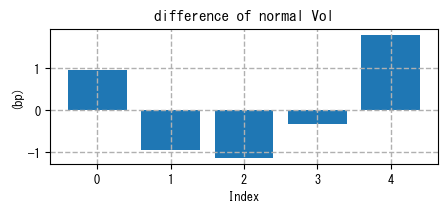

In [13]:
dfHLPR = hlprDTL(swptnHLP) ; display(dfHLPR)
# ノーマルボラとHWノーマルボラの差の表示
plt.rcParams.update({"figure.figsize":[len(dfHLPR.index),1.75]})

fig, ax = plt.subplots()
ax.bar(dfHLPR.index, (dfHLPR.mktNmVol-dfHLPR.impNmVol)*10000)
ax.set_title('difference of normal Vol') ; ax.grid(linestyle='--',linewidth=1) 
ax.set_xlabel('Index') ; ax.set_ylabel('(bp)');

In [14]:
plt.rcParams.update({"figure.figsize":[4.5,2.5]})

In [15]:
# ヘルパーの1Yx5Yスワップションをバミューダンへ修正
exprSCD    = [calJP.advance(dd,-2,DD) for dd in list(fixSCD)] 
swptnOBJb = ql.Swaption(swapOBJ, ql.BermudanExercise(exprSCD))

# バミューダン評価
treeSwpENG = ql.TreeSwaptionEngine(hwMDLb, 12*6)
swptnOBJb.setPricingEngine(treeSwpENG); print(f'NPV: {swptnOBJb.NPV():,.6%}')

NPV: 1.137061%


In [16]:
# ステップ数=1で評価
swptnOBJ.setPricingEngine(ql.TreeSwaptionEngine(hwMDL, 1))
print(f'1ステップ スワップションNPV: {swptnOBJ.NPV():,.8%}')

1ステップ スワップションNPV: 0.52635177%


In [17]:
# X1パスを(tmGRD, xPT)でnPT本描写
def draw_xPT(nPT=5, deco=False ):
    if deco: #(3本ツリーグラフを特殊サイズで描写し、装飾)
        _,ax = plt.subplots(figsize=(3,2)) 
        # テキスト記入 (xA, yA,...は座標位置)
        xA=0.3; yA=0.003; xB = 0.87; xC = 0.84; yB = 0.005
        ax.text(xA,yA,       "1/6"); ax.text(xB,yB,    "0.6777%")
        ax.text(xA,yA/10,    "4/6"); ax.text(xB,yB/10, "0.0000%")
        ax.text(xA,-yA+0.001,"1/6"); ax.text(xC,-yB,  "-0.6777%")
    else :
        _,ax = plt.subplots()
    # 一般グラフと装飾        
    for ii in range(nPT): ax.plot(tmGRD, xPT[ii])
    ax.set_title("x process simulation"); ax.grid(linestyle='--',linewidth=1)
    ax.set_ylabel('X'); ax.set_xlabel('ステップ')
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(1,3))

# 3つのディスカウントカーブをdfSCDとx1DFから描写
def draw_xDF(dfSCD, x1DF):
    _,ax = plt.subplots(figsize=(4.5,1.7))
    for ii in x1DF: ax.plot(dfSCD.cfYR, ii) 
    # グラフ装飾
    ax.grid(linestyle='--',linewidth=1)
    ax.set_ylabel('DF (HW-割引債価格)')
    ax.set_xlabel('年') ; ax.set_xticks(dfSCD.cfYR)
    ax.xaxis.set_major_formatter(mtick.FormatStrFormatter('%.2f')) ;

dX:0.6777%


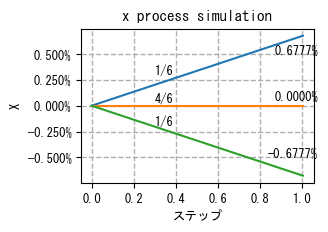

In [18]:
# Xtの確率分布 (Brigo p78)
dT = dcA365.yearFraction(tradeDT, exprDT) 
dX = sgm*np.sqrt(3/(2*aa)*(1-np.exp(-2*aa*dT))); print(f'dX:{dX:.4%}')
x1Val = nA([dX, 0, -dX]) ; x1Prob = [1/6, 4/6, 1/6]     # x1設定と対応確率
# グラフ描写(xPTとtmGRDの準備)
xPT = [[0,dX], [0,0], [0,-dX]] ; tmGRD = list(ql.TimeGrid(dT,1))
draw_xPT(3,True)

In [19]:
#原資産(1Yx5Yｽﾜｯﾌﾟ)ｷｬｯｼｭﾌﾛｰ (cfYR:ｷｬｯｼｭﾌﾛｰ日までの年数, tnrLST:ﾃﾅｰ, nowDF:現在のDF)
cfYR   = [dcA365.yearFraction(tbCrvOBJ.referenceDate(), xx)   for xx in fixSCD]
tnrLST = np.diff([dcA365.yearFraction(fixSCD.startDate(), xx) for xx in fixSCD])
nowDF  = [tbCrvOBJ.discount(xx)                               for xx in fixSCD]
# データフレーム化
dfSCD = pd.DataFrame(dict( cfYR=cfYR, tnrLST=np.append(0,tnrLST), nowDF=nowDF ))
dfSCD.style.format({'cfYR':'{:.3f}', 'tnrLST':'{:.3f}'})

,cfYR,tnrLST,nowDF
0,1.000,0.000,0.998477
1,1.512,0.512,0.997170
2,2.003,0.490,0.995896
3,2.512,0.510,0.994457
4,3.008,0.496,0.993059
5,3.510,0.501,0.991408
6,4.005,0.496,0.989777
7,4.510,0.504,0.987776
8,5.003,0.493,0.985823
9,5.510,0.507,0.983253


x1DF[0]: [1.      0.99525 0.99075 0.98602 0.98148 0.97672 0.97208 0.96709 0.96228
 0.95684 0.95159]


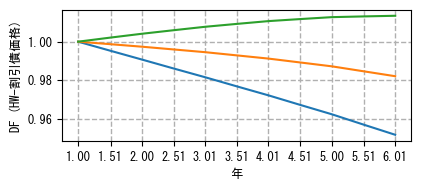

In [20]:
# Hull-White B関数 V関数 A関数
def BB(tt,TT,aa):
    return (1-np.exp(-aa*(TT-tt)))/aa
def VV(tt,TT, aa, sgm): 
    return (sgm**2/aa**2)*(TT-tt +(2/aa)*np.exp(-aa*(TT-tt))\
        -(1/(2*aa))*np.exp(-2*aa*(TT-tt))-3/(2*aa))
def AA(tt,TT, aa, sgm):
    '''sgm:short rate Vol'''
    return 0.5*(VV(tt,TT,aa,sgm)-VV(0,TT,aa,sgm)+VV(0,tt,aa,sgm))

# HW価格式の係数の算出
mktCvLST= nA([xx/dfSCD.nowDF[0]              for xx in dfSCD.nowDF])
bbLST   = nA([BB(dfSCD.cfYR[0], xx, aa)      for xx in dfSCD.cfYR]) 
aaLST   = nA([AA(dfSCD.cfYR[0], xx, aa, sgm) for xx in dfSCD.cfYR]) 
# 各x1要素によるｷｬｯｼｭﾌﾛｰ日のDF
x1DF    = [mktCvLST * np.exp(aaLST-xx*bbLST) for xx in x1Val]
print('x1DF[0]:', x1DF[0]) ; draw_xDF(dfSCD, x1DF)  

In [21]:
# Brigo p80にある3番目の式でalph0を算出
alph0  = -np.log(tbCrvOBJ.discount(exprDT))/dT
exprDF = np.exp(-(0.5*x1Val*dT**2+alph0*dT))          #式9.52のeの肩のrの積分
print(f'alph0:{alph0:.5%}', '  exprDF:', exprDF)      # DF at expiry

alph0:0.15069%   exprDF: [0.99507 0.99849 1.00191]


In [22]:
#ITMレート計算 (x1annu:アニュイティ)
x1annu = nA([np.sum( xx*nA(dfSCD.tnrLST) ) for xx in x1DF])
itmRT  = nA([(1-xx[-1]) for xx in x1DF])/x1annu - cpnRT 
print('(itmRT) before:', itmRT, end=' ')

# マイナス要素をゼロへ置き換え (otmPOS:otmの位置)
otmPOS = np.where(itmRT<0.0)
itmRT[otmPOS] = 0 ; print('after:', itmRT)

# スワップションNPV
swptnNPV = np.sum(nA([itmRT*x1annu])*exprDF*x1Prob) 
print(f'swptnNPV: {swptnNPV:,.5%}')

(itmRT) before: [ 0.00635  0.00004 -0.00625] after: [0.00635 0.00004 0.     ]
swptnNPV: 0.52659%


In [23]:
np.set_printoptions(precision=6,suppress=True) 

In [24]:
# Brigo p76 M^T(s,t)式
def TfwdDRFT(s,t,T):
    itemA = 1- np.exp(-aa*(t-s))
    itemB = np.exp(-aa*(T-t))-np.exp(-aa*(T+t-2*s))
    return (sgm**2/aa**2)*(itemA-0.5*itemB)

tFwd = TfwdDRFT(0,dT,dT)  ; print(f'TfwdDRFT:{tFwd:.4%}')
Tx1Val = nA([dX-tFwd, 0-tFwd, -dX-tFwd]) ; print(Tx1Val)

TfwdDRFT:0.0008%
[ 0.006769 -0.000008 -0.006785]


In [25]:
np.set_printoptions(precision=5,suppress=True) 

Tx1DF[0]: [1.      0.99525 0.99075 0.98603 0.9815  0.97674 0.97211 0.96712 0.96231
 0.95687 0.95163]


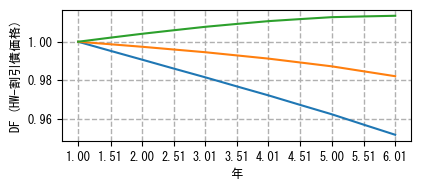

In [26]:
# 各x1要素によるｷｬｯｼｭﾌﾛｰ日のDF
Tx1DF    = [mktCvLST * np.exp(aaLST-xx*bbLST) for xx in Tx1Val]
print('Tx1DF[0]:', Tx1DF[0]) ; draw_xDF(dfSCD, Tx1DF)  

In [27]:
#ITMレート計算 (x1annu:アニュイティ)
x1annu = nA([np.sum( xx*nA(dfSCD.tnrLST) ) for xx in Tx1DF])
itmRT  = nA([(1-xx[-1]) for xx in Tx1DF])/x1annu - cpnRT 
print('(itmRT) before:', itmRT, end=' ')

# マイナス要素をゼロへ置き換え (otmPOS:otmの位置)
otmPOS = np.where(itmRT<0.0)
itmRT[otmPOS] = 0 ; print('after:', itmRT)

# スワップションNPV
swptnNPV = np.sum(nA([itmRT*x1annu])*x1Prob)* tbCrvOBJ.discount(dT)
print(f'swptnNPV: {swptnNPV:,.5%}')

(itmRT) before: [ 0.00634  0.00003 -0.00625] after: [0.00634 0.00003 0.     ]
swptnNPV: 0.52541%


In [28]:
import myUtil as mu ; from myABBR import *

tradeDT = jDT(2022,8,19) ; mu.setEvDT(tradeDT)
# Tiborカーブ設定
crvDATA = [ ('depo','6m',0.13636),  ('swap','1y',0.15249),  ('swap','18m',0.18742), 
            ('swap','2y',0.20541),  ('swap','3y',0.23156),  ('swap','4y',0.25653), 
            ('swap','5y',0.28528),  ('swap','6y',0.32341),  ('swap','7y',0.36591), 
            ('swap','8y',0.40906),  ('swap','9y',0.45471),  ('swap','10y',0.50224)]
tbrIX, tbCrvOBJ, tbCrvHDL, tbParRT = mu.makeTiborCurve(crvDATA)  
# check
print( f'reference:{tbCrvOBJ.referenceDate().ISO()}', end='  ')

# スワップションヘルパーの準備  volDATA = (stYR, swpTNR, nmVOL)
volDATA  = [(1,5,36.06), (2,4,34.28), (3,3,34.14), (4,2,34.99), (5,1,37.15)]
othrPARA = [ql.BlackCalibrationHelper.RelativePriceError,
                                               ql.nullDouble() ,1.0, ql.Normal]
swptnHLP = [ql.SwaptionHelper(calJP.advance(tradeDT,stY,YY), pD(tnr,YY), 
            mu.sqHDL(nV/10000), tbrIX,pdFreqSA,dcA365,dcA365, tbCrvHDL,*othrPARA)
         for (stY, tnr, nV) in volDATA ]

# 1Yx5Yスワップションの準備
swEffDT,           swMatDT,    ntlAMT,   cpnRT,      sprdRT                        =\
jDT(2023,8,23), jDT(2028,8,23),  1,    0.35787/100,   0.0

fixSCD = ql.Schedule(swEffDT, swMatDT, pdFreqSA, calJP, mFLLW, mFLLW, dtGENb, EoMf)
swapOBJ = ql.VanillaSwap(ql.VanillaSwap.Payer, ntlAMT, fixSCD,         cpnRT, dcA365,
                                                       fixSCD, tbrIX, sprdRT, dcA365)
exprSCD = [calJP.advance(dd,-2, DD) for dd in list(fixSCD)[:-1]] 
swptnOBJb = ql.Swaption(swapOBJ, ql.BermudanExercise(exprSCD))

reference:2022-08-23  

In [29]:
# 1.GSRモデル初期設定
aa,sgmG = [mu.sqHDL(0.03)], [mu.sqHDL(1/10000)]*6
sgmDT   = [ql.as_swaption_helper(hh).swaptionExpiryDate() for hh in swptnHLP]
gsrMDL  = ql.Gsr(tbCrvHDL, sgmDT, sgmG, aa)
gsrENG  = ql.Gaussian1dSwaptionEngine(gsrMDL, 64, 7.0, True, False, tbCrvHDL)

# 2.スワップションヘルパーswptnHLPのエンジンはgsrENG
for hh in swptnHLP: hh.setPricingEngine(gsrENG)

# 3. カリブレーションと確認 
endCRT = ql.EndCriteria(10000, 100, 1e-6, 1e-8, 1e-8)
gsrMDL.calibrateVolatilitiesIterative(swptnHLP, ql.LevenbergMarquardt(), endCRT)
aa     = nA(gsrMDL.params())[0]                    # ql.Arrayはスライスが出来ない
sgmG   = nA(gsrMDL.params())[1:]                   # ので、numpy配列に変換 
print (f" aa = {aa},  sgmG = {sgmG}")                  
dfHLPR = hlprDTL(swptnHLP) ; display(dfHLPR)

# 4. バミューダン評価
swptnOBJb.setPricingEngine(gsrENG) ; print(f'gsr-NPV: {swptnOBJb.NPV():,.6%}')

 aa = 0.03,  sgmG = [0.00397 0.00354 0.00369 0.00405 0.00478 0.0001 ]


,swEffDT,swMatDT,exprDT,cpnRT,opSTRK,mktNmVol,bacPRC,hwPRC,impNmVol
0,2023-08-23,2028-08-23,2023-08-21,0.003579,0.003579,0.003606,0.007148,0.007148,0.003606
1,2024-08-21,2028-08-21,2024-08-19,0.003827,0.003827,0.003428,0.007656,0.007656,0.003428
2,2025-08-21,2028-08-21,2025-08-19,0.004159,0.004159,0.003414,0.006991,0.006991,0.003414
3,2026-08-21,2028-08-21,2026-08-19,0.004581,0.004581,0.003499,0.005506,0.005506,0.003499
4,2027-08-23,2028-08-23,2027-08-19,0.005158,0.005158,0.003715,0.003264,0.003264,0.003715


gsr-NPV: 1.130087%


In [30]:
# 2x4スワップションNPV計算
# 1.日数計算
yr0  = (sgmDT[0]-tradeDT)/365 ; yr1  = (sgmDT[1]-tradeDT)/365 ; yr01 = yr1-yr0
print(f'yr0:{yr0:.4f}年,  yr1:{yr1:.4f}年,  yr01:{yr01:.4f}年')

# 2.ボラティリティの計算
sgmG2y = np.sqrt(( yr0*sgmG[0]**2 + yr01*sgmG[1]**2 )/yr1)
print(f'2年sigma:{sgmG2y:.4%}', end=',  ')

# 3.Jamshidianエンジン
hwMDL  = ql.HullWhite(tbCrvHDL, 0.03, sgmG2y)
jamENG = ql.JamshidianSwaptionEngine(hwMDL)

# 4.ヘルパーのキャストと評価
sw1     = ql.as_swaption_helper(swptnHLP[1]).underlyingSwap()
swtnOBJ = ql.Swaption(sw1, ql.EuropeanExercise(sgmDT[1]))
swtnOBJ.setPricingEngine(jamENG)
print(f'jam-NPV:{swtnOBJ.NPV():,.4%}')

yr0:1.0055年,  yr1:2.0027年,  yr01:0.9973年
2年sigma:0.3762%,  jam-NPV:0.7672%
